Imports and Constants

In [1]:
import sys, os, multiprocessing, csv, copy

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from xgboost import XGBClassifier

import numpy as np
import math

import pandas as pd

np.random.seed(42)

INPUT_PATH = os.path.join(".", "CSVs", "inputs")
OUTPUT_PATH = os.path.join(".", "CSVs", "outputs")
RANDOM_STATE = 42

Get the data from the CSVs

In [2]:
test = pd.read_csv(os.path.join(INPUT_PATH, "test.csv"))
train = pd.read_csv(os.path.join(INPUT_PATH, "train.csv"))

train_X = train.drop(axis = 1, columns = "Survived")
train_y = train["Survived"]
marker = len(train_X)

dataset = pd.concat([train_X, test], ignore_index=True)

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Function for outputing scores

In [4]:
def write_out(vals, filename):
    file_path = os.path.join(OUTPUT_PATH, filename) + ".csv"

    with open(file_path, 'w', newline='') as csvfile:
        # creating a csv writer object  
        csvwriter = csv.writer(csvfile)

        # writing the fields  
        csvwriter.writerow(["PassengerId","Survived"])
        for num in range(418):
            csvwriter.writerow([num+892, int(vals[num])])

'''
scores: (accuracy)
    SGD classifier 0.73205
    Random Forest 0.76555
    SVC 0.78708
'''

'\nscores: (accuracy)\n    SGD classifier 0.73205\n    Random Forest 0.76555\n    SVC 0.78708\n'

Some data preperation

In [5]:
class AttributeDropper(BaseEstimator, TransformerMixin):
    def __init__(self, attribs):
        self.attribs = attribs
    def transform(self, X):
        return X.drop(columns = self.attribs)
    def fit(self, X, y=None):
        return X
    def fit_transform(self, X, y=None):
        r_val = self.transform(X)
        self.cols = r_val.columns
        return r_val

In [6]:
class AgeEstimator(BaseEstimator, TransformerMixin):
    def transform(self, X):
        return self
    def fit(self, X, y=None):
        valid = X.dropna(subset=['Age'], inplace = False)
        missing = X[X.isnull()['Age']]
        valid_X = valid.drop(columns=['Age'], inplace=False)

        self.regr = Lasso(alpha = 0.1).fit(valid_X, valid["Age"])
        X.loc[X.isnull()['Age'], 'Age'] = self.regr.predict(missing.drop(columns = ['Age']))
        
        return X
    def fit_transform(self, X, y=None):
        return self.fit(X, y)

In [7]:
class Filler(BaseEstimator, TransformerMixin):
    def transform(self, X):
        return self
    def fit(self, X, y=None):
        for x in X:
            if (x != 'Age') & (x != 'Sex') & (x != 'Embarked'):
                median = X[x].median()
                X[x].fillna(median, inplace=True)
        return X
    def fit_transform(self, X, y=None):
        return self.fit(X)

In [8]:
class Encoder(BaseEstimator, TransformerMixin):
    def transform(self, X):
        df = pd.DataFrame({'class_f':[], 'class_s':[], 'class_t':[],
                          'emb_s':[], 'emb_c':[], 'emb_q':[],
                          'officer':[], 'royalty':[], 'mr':[], 'mrs':[], 'miss':[], 'master':[]})
        class_dict = {1:'class_f', 2:'class_s', 3:'class_t'}
        emb_dict = {'S':'emb_s', 'C':'emb_c', 'Q':'emb_q'}
        title_dict = {
            'capt':'officer',
            'col':'officer',
            'major':'officer',
            'jonkheer':'royalty',
            'don':'royalty',
            'sir':'royalty',
            'dr':'officer',
            'rev':'officer',
            'the countess':'royalty',
            'mme':'mrs',
            'mlle':'miss',
            'ms':'mrs',
            'mr':'mr',
            'mrs':'mrs',
            'miss':'miss',
            'master':'master',
            'lady':'royalty'
        } #dict taken from https://www.ahmedbesbes.com/blog/kaggle-titanic-competition
        
        for i in X.index:
            class_key = X.at[i, 'Pclass']
            emb_key = X.at[i, 'Embarked']
            
            if class_key in class_dict:
                df.at[i, class_dict[class_key]] = 1
            if emb_key in emb_dict:
                df.at[i, emb_dict[emb_key]] = 1
            
            name = X.at[i, 'Name'].lower()
            for key in title_dict.keys():
                if name.find(key) > -1:
                    df.at[i, title_dict[key]] = 1
                    break
        
        X = X.mask(X == 'male', 0)
        X = X.mask(X == 'female', 1)
                
        df.fillna(0, inplace = True)
        return pd.concat((df, X.drop(columns = ['Pclass', 'Embarked', 'Name'])), join = 'inner', axis = 1)
    def fit(self, X, y=None):
        return X
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [9]:
class FamilyCombiner(BaseEstimator, TransformerMixin):
    def transform(self, X):
        fam = []
        for i in X.index:
            num = X.at[i, 'SibSp'] +  X.at[i, 'Parch']
            fam.append(num)
        X['family_size'] = fam
        X.drop(columns = ['SibSp', 'Parch'], inplace = True)
        return X
    def fit(self, X, y=None):
        return X
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

drop_attribs = ['Cabin', 'PassengerId', 'Ticket'] #need to be dropped before the age estimator, aren't good estimators
drop_attribs2 = ['royalty', 'mrs', 'master', 'officer', 'emb_s', 'emb_c', 'emb_q'] #according to a random forest classifier, these are the least important features

pipeline = Pipeline([
    ('encoder', Encoder()),
    ('family_comb', FamilyCombiner()),
    ('dropper', AttributeDropper(drop_attribs)),
    ('filler', Filler()),
    ('age_est', AgeEstimator()),
    ('addtl_dropper', AttributeDropper(drop_attribs2)), #comment out this line and rerun the cell with the mathplot to see the importances of these features, also uncomment the line commented out in the cell below this 
    ('scaler', MinMaxScaler())
])

In [11]:
data_prep = pipeline.fit_transform(dataset)
cols = pipeline.named_steps['addtl_dropper'].cols #comment here
#cols = pipeline.named_steps['dropper'].cols #uncomment here

Here we split the prepared data back into two seperate ndarrays, the test and training vals

In [12]:
train_X_prep = data_prep[:marker]
test_prep = data_prep[marker:]

Here's a variety of estimators

In [13]:
#Random Forest Regressor

param_grid = [{
    'n_estimators': [130, 150, 160, 170, 180, 200],
    'max_depth': [6, 7, 8, 9, 10],
}]

forest_clf = RandomForestClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                           scoring='f1',
                           return_train_score=True)

grid_search.fit(train_X_prep, train_y)
random_forest = grid_search.best_estimator_
print(grid_search.best_params_)

forest_vals = random_forest.predict(test_prep)
write_out(forest_vals, "Random_Forest")

{'max_depth': 9, 'n_estimators': 150}


<BarContainer object of 9 artists>

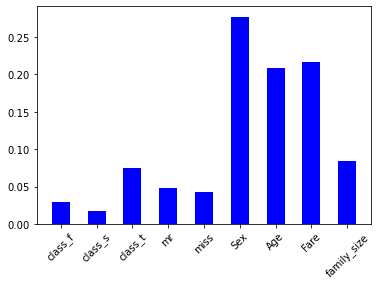

In [14]:
import matplotlib.pyplot as plt

vals = random_forest.feature_importances_
plt.xticks(rotation=45)
plt.bar(range(1, len(vals) + 1), vals, tick_label = cols,
        width = 0.5, color = ['blue'])

In [15]:
#Support Vector Classifier
svc = SVC(probability = True, kernel = 'rbf')
svc.fit(train_X_prep, train_y)
svc_vals = svc.predict(test_prep)
write_out(svc_vals, "SVC")

In [16]:
voting_clf = VotingClassifier(estimators = [("rf", random_forest), ("svc", svc)], voting = "soft")
voting_clf.fit(train_X_prep, train_y)

voting_vals = voting_clf.predict(test_prep)
write_out(voting_vals, "Voting(soft, rf and svc)")

In [17]:
#XGDboosting
import xgboost as xgb

#params = {
#    'max_depth' : [3, 4, 5, 6, 7, 8], 'eta' : [.05, .06, .075, .1], 'gamma': [.3, .35, .4, .45, .5], #grid search to get a feel for the best params
#    'objective' : ['binary:hinge']
#}


#XGBsearch_CV = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid = params,
#                            cv=5)

#grid_result = XGBsearch_CV.fit(train_X_prep, train_y)
#print(grid_result.best_params_)

dtrain = xgb.DMatrix(train_X_prep, label=train_y)
dtest = xgb.DMatrix(test_prep)


param = {'max_depth': 6, 'eta': 0.04, 'objective': 'binary:hinge'}
XGB_est = xgb.train(param, dtrain, 100)

# make prediction
XGB_vals = XGB_est.predict(dtest)
write_out(XGB_vals, "XGB")

In [18]:
#voting between xgb and svc (need to run XGB again with different objective binary:logistic)
#voting_vals2 = []
#for i in range(418):
#    voting_vals2.append(round((svc_prob[i, 1] + XGB_vals[i]) / 2))
#write_out(voting_vals2, "voting(soft, xgb and svc)")

Some testing, feel free to ignore

In [19]:
breakpoint = here #JuypterLabs does not support breakpoints, so this is just a way to stop execution here

NameError: name 'here' is not defined

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import AdaBoostRegressor

param_grid = [{'n_estimators': [100, 150, 200, 250, 300], 'max_features': [2, 3, 4, 5, 6, 7, 8]}]
class AgeEstimatorTest(BaseEstimator, TransformerMixin):
    def __init__(self, params = param_grid):
        self.params = params
    def transform(self, X):
        return self
    def fit(self, X, y=None):
        temp = X.drop(columns=['Age'])
        self.regr = Lasso(alpha = 0.1).fit(temp, X["Age"])
        return X

    def fit_transform(self, X, y=None):
        return self.fit(X, y)

In [ ]:
drop_attribs1 = ["Name", "Cabin", "PassengerId", "Ticket"]
drop_attribs2 = ["Name", "Cabin", "PassengerId", "Ticket", "Age"]

test_pipeline1 = Pipeline([
    ('dropper', AttributeDropper(drop_attribs1)),
    ('filler', Filler()),
    ('cust_enc', CustEncoder()),
    ('family_comb', FamilyCombiner()),
    ('hot_encoder', HotEncoder()),
    ('age_est', AgeEstimatorTest())
])

test_pipeline2 = Pipeline([
    ('dropper', AttributeDropper(drop_attribs2)),
    ('filler', Filler()),
    ('cust_enc', CustEncoder()),
    ('family_comb', FamilyCombiner()),
    ('hot_encoder', HotEncoder())
])

In [ ]:
test_set = dataset.dropna(subset = ["Age"])
len(test_set)

In [ ]:
shuffle = test_set.sample(frac = 1, axis = 0)
sample = shuffle[:820]
s_test = shuffle[820:]

In [ ]:
sample_prep = test_pipeline1.fit_transform(sample)
s_test_prep = test_pipeline2.fit_transform(s_test)

In [ ]:
age = s_test["Age"]
age2 = sample["Age"]

age_est = test_pipeline1.named_steps['age_est']

score = age_est.regr.score(s_test_prep, age)
score2 = age_est.regr.score(sample_prep.drop(columns = "Age"), age2)
print(score, score2)

In [ ]:
print(train_X_prep[:3])

In [ ]:
train_combined = np.concatenate((train_X_prep, np.vstack(train_y)), axis = 1)

In [ ]:
train_mat = xgb.DMatrix(train_combined)